<a href="https://colab.research.google.com/github/G-Assimila/pvlncc2025/blob/main/notebooks/LNCC_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Workshop da Escola de Verão do Laboratório Nacional de Computação Científica (LNCC)

###Mini-curso: Assimilação de Dados por Aprendizado de Máquina


####Neste notebook iremos desenvolver um modelo que replica o Atrator de Lorenz

####Para isso, definiremos as equações do Atrator para gerar o conjunto de dados. Iremos prever a trajetória dos pontos baseados em pontos passados

In [ ]:
!pip install optuna
!pip install optuna-integration[keras]

In [ ]:
import os
import keras
import random
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn import preprocessing
from optuna.trial import TrialState
from sklearn.preprocessing import MinMaxScaler
from optuna.integration import KerasPruningCallback

### funções auxiliares

In [ ]:
def enable_determinism(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

def get_best_model(best_trial):
  final_model = keras.models.Sequential()

  n_layers = best_trial['n_layers']

  for i in range(n_layers):
    final_model.add(layers.Dense(best_trial[f"n_units_l{i}"], activation="relu"))

  final_model.add(layers.Dense(3, activation='linear'))

  lr = best_trial["learning_rate"]

  final_model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=lr)
    )

  return final_model

enable_determinism()

## Definição do Atrator Estranho de Lorenz

### Fonte: [Atrator de Lorenz no Matplotlib](https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html)

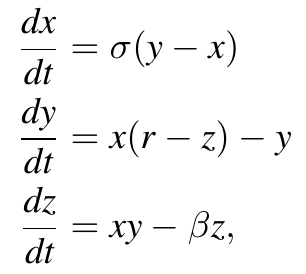


## Vamos gerar os dados de treinamento a partir da resolução das equações

In [ ]:
def lorenz_atractor(x_y_z, s=10, r=28, b=2.667):
    x, y, z = x_y_z

    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z

    return np.array([x_dot, y_dot, z_dot])

### Gerando o conjunto de dados

In [ ]:
dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))
xyzs[0] = (0., 1., 1.05)

for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz_atractor(xyzs[i]) * dt

ax = plt.figure(figsize=(12, 6)).add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Atrator de Lorenz")

plt.show()

## Vamos criar um modelo baseado em Redes Neurais para emular o Atrator de Lorenz



### Inicialmente, precisamos dividir o conjunto de dados em duas partes: treino e teste
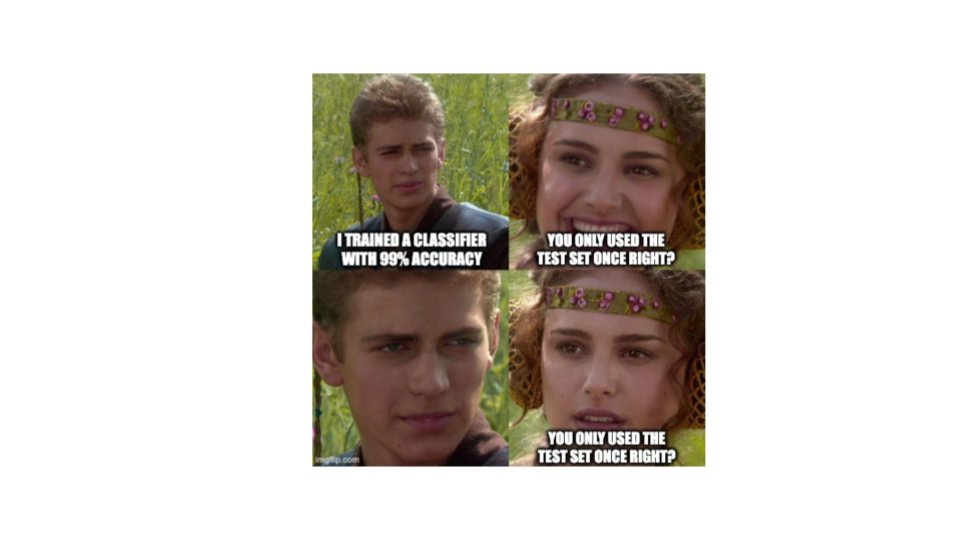

[Leakage and the Reproducibility Crisis in ML-based Science](https://reproducible.cs.princeton.edu/)

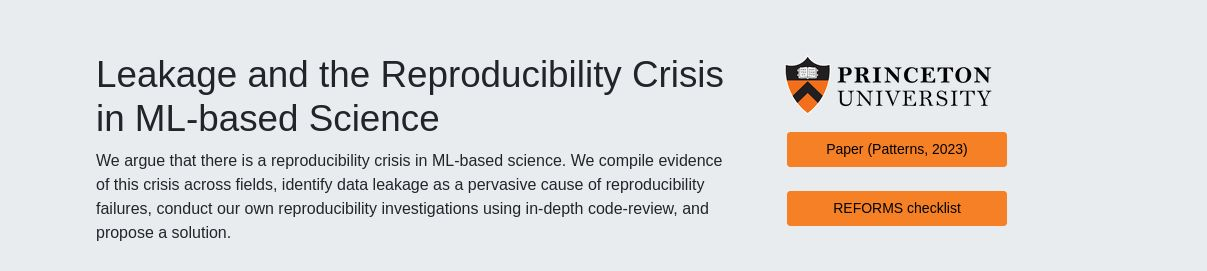

In [ ]:
train_size = int(num_steps * 0.8)

train_set = xyzs[:train_size]
test_set = xyzs[train_size:]

print(f"Train size: {train_size}")
print(f"Test size: {num_steps - train_size}")

## Agora, vamos definir um espaço de busca para definir os hiperparametros da Rede Neural

### Definindo o espaço de busca:

#### Hiperparametros:

| Hyperparametro        | Tipo         | Faixa/Valores                     | Escala logaritmica |
|-----------------------|--------------|-----------------------------------|-----------|
| **n_layers**           | Integer      | 2 até 4                           | Não        |
| **n_units_l{layer}**   | Integer      | 32 até 64                         | Não        |
| **learning_rate**      | Float        | 1e-4 até 1e-2                     | Sim       |



### Para fazer a otimização dos hiperparametros, vamos utilizar o framework Optuna: [Site oficial](https://optuna.org/)

In [ ]:
def get_model(trial):

  n_hidden_layers = trial.suggest_int("n_layers", 2, 4)
  model = keras.models.Sequential()

  #passando pelo número de camadas escondidas
  for layer in range(n_hidden_layers):
    #adicionando 'neuronios' à cada uma das camadas
    n_hidden_units = trial.suggest_int(f"n_units_l{layer}", 32, 64, log=False)
    model.add(layers.Dense(n_hidden_units, activation="relu"))

  #finalmente, a última camada terá três neuronios (um para cada coordenada)
  model.add(layers.Dense(3, activation='linear'))

  lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

  model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=lr),
    metrics=["mean_squared_error"],
  )

  return model


## Função objetivo a ser otimizada

### Aqui, definimos uma parcela do conjunto de treinamento para ser usado como conjunto de validação

#### Idealmente, utilizariamos a estratégia K-Cross validation, para termos uma maior confiança nos resultados

#### Como o objetivo deste exemplo é exercitar os conceitos, vamos usar a estratégia de houldout validation. Ou seja, usaremos um conjunto de validação fixo para cada conjunto de hiperparametros

In [ ]:
def objective(trial):

  keras.backend.clear_session()

  validation_size = int(train_size * 0.20)

  X_train = train_set[:validation_size]
  y_train = train_set[1:validation_size+1]


  X_val = train_set[validation_size:-1]
  y_val = train_set[validation_size+1:]


  scaler = MinMaxScaler()

  X_train_scaled = scaler.fit_transform(X_train)
  X_val_scaled = scaler.transform(X_val)


  model = get_model(trial)

  model.fit(
        X_train_scaled,
        y_train,
        batch_size=32,
        callbacks=[KerasPruningCallback(trial, "val_mean_squared_error")],
        epochs=30,
        validation_data=(X_val_scaled, y_val),
        verbose=1)


  score = model.evaluate(X_val_scaled, y_val, verbose=0)
  return score[1]

### Criação do experimento

* *Study*: otimização baseada em uma função objetivo

* *Trial*: uma única execução da função objetivo



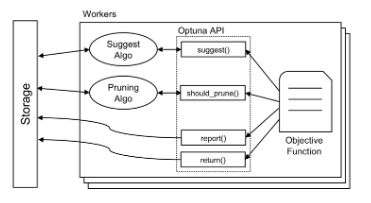

* [Optuna - TPE](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html)
* [Gaussian Mixture](https://scikit-learn.org/stable/modules/mixture.html)


In [ ]:
if "db.sqlite3" in os.listdir():
  os.remove("db.sqlite3")

storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(direction="minimize",
                            storage="sqlite:///db.sqlite3",
                            study_name="NN_hyperparameter_tuning")

study.optimize(objective, n_trials=10)

pruned = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

### Acessando os valores obtidos através da otimização

In [ ]:
trial = study.best_trial

print(f"Value: {trial.value}")

In [ ]:
print("Parâmetros escolhidos: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

### Carregando os hiperparametros encontrados

In [ ]:
X_train = xyzs[:train_size]
y_train = xyzs[1:train_size+1]

X_test = xyzs[train_size:-1]
y_test = xyzs[train_size+1:]

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Treinando o modelo final

In [ ]:
best_model = get_best_model(trial.params)
history = best_model.fit(
      X_train_scaled,
      y_train,
      batch_size=32,
      epochs=30,
      verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.title('MSE de treinamento')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Predições

In [ ]:
test_score = best_model.evaluate(X_test_scaled, y_test, verbose=0)
predictions = best_model.predict(X_test_scaled)
print(f"Test score: {test_score}")

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(*X_test.T, lw=0.5)
ax1.set_xlabel("X Axis")
ax1.set_ylabel("Y Axis")
ax1.set_zlabel("Z Axis")
ax1.set_title("Referência")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(*predictions.T, lw=0.5)
ax2.set_xlabel("X Axis")
ax2.set_ylabel("Y Axis")
ax2.set_zlabel("Z Axis")
ax2.set_title("Predições")

plt.tight_layout()
plt.show()


## Agora é com você!

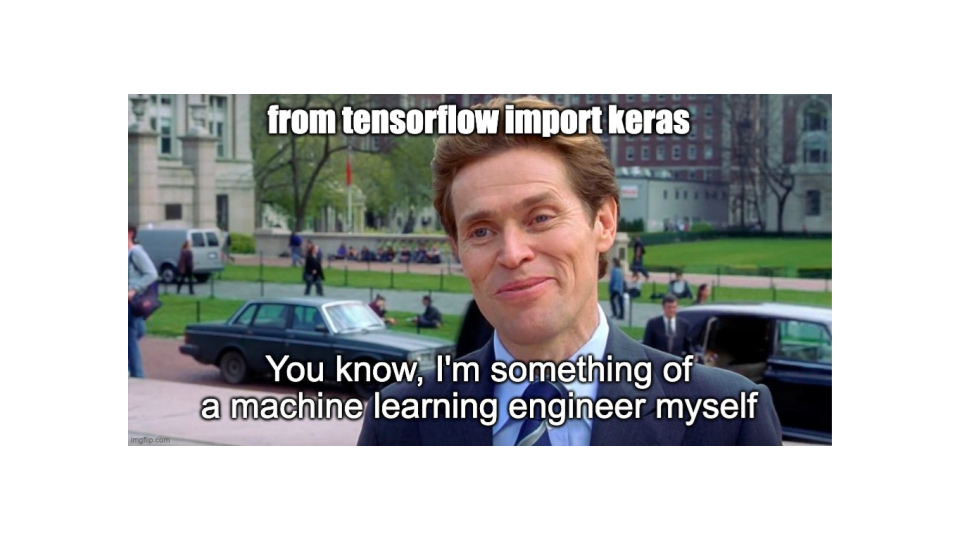

[I'm something of a Machine Learning Engineer Myself](https://posts.specterops.io/learning-machine-learning-part-1-introduction-and-revoke-obfuscation-c73033184f0)

### Treinamos nosso modelo para prever o próximo ponto a partir do ponto anterior.

### Entretanto, o que seria interessante *mesmo* seria prever a trajetória completa a partir apenas da condição inicial!

### Em termos técnicos, desenvolver um modelo **auto-regressivo**, em que o pŕoximo input do modelo é a sua previsão anterior. Dessa forma, poderíamos avaliar se nosso modelo de fato aprendeu a dinâmica do modelo de Lorenz.

####Para pensar...

    

*  Será que a arquitetura de Rede Neural escolhida é capaz de fazer isso?
*  Caso negativo, qual outra arquitetura (ou algoritmo de aprendizado de máquina) seria capaz de realizar essa tarefa?


    


## Referências



*   [Learning the Lorenz System](https://verzep.github.io/Learning-Lorenz/)

*   
[Aprendizado por ensemble](https://ricardomatsumura.medium.com/aprendizado-por-ensembles-7cf80117446
)
* [Árvores de Decisão](https://ricardomatsumura.medium.com/aprendizado-com-%C3%A1rvores-de-decis%C3%A3o-73d874664d1)

*   [Documentação do scikitlearn](https://scikit-learn.org/stable/index.html)
*   [Documentação do Keras](https://keras.io/)
*   [Documentação do Optuna](https://optuna.readthedocs.io/en/stable/)

*   [Atrator de Lorenz no matplotlib](https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html)
*   [Escola de verão 2021 - H2IA](https://github.com/H2IA/escola-de-verao-2021)



*   [Learning Machine Learning Part 1: Introduction and Revoke-Obfuscation](https://posts.specterops.io/learning-machine-learning-part-1-introduction-and-revoke-obfuscation-c73033184f0)





